### Standardized Mooring Supply Chain Analysis

About: This notebook is a practical approach to analyzing supply chain elements that must occur prior to installation. This example focuses on the station-keeping components or mooring system of a floating offshore wind farm. The key components of this mooring system are Chains, Ropes, and Anchors. Each component's supply chain is simplified as: 
1) Production: The manufacturing phase that is defined by a takt_time (hours per unit or unit-length)
2) Transportation: The transit phase that moves components from production site to marshalling port
3) Storage/Assembly: The laydown phase that unloads components and stores them prior to installation

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ORBIT import ProjectManager, load_config

from ORBIT.phases.design import CustomMooringSystemDesign
from ORBIT.phases.install import MooringSystemSupplyChain

In [3]:
INPUTS = os.path.join(os.getcwd(), "inputs")
RESULTS = os.path.join(os.getcwd(), "results")
if not os.path.exists(RESULTS):
    os.mkdir(RESULTS)

#### Morro Bay config
See the file `inputs/custom_MorroBay.yaml` for all the ORBIT inputs that 
describe this installation site. The project has a capacity of 600 MW, 
comprised of 40 15MW turbines on semi-submersible platforms. Each platform 
has 6 lines and 6 anchors that fix it to the seafloor. Average depth = ( ) m

Rather than using ORBIT's standard curve-fit design tools, this model reads in an optimized design from a csv file, `inputs/custom_mooring_MorroBay_full.csv`. The mooring system is a semi-taut design where each line consists of a bottom chain, synthetic rope, and top chain. The bottom chain is connected to a pile anchor.

(Optional) specify a weather file to see how weather constraints impacts 
installation. Status: Unused in SupplyChain

In [4]:
config_MB = load_config(os.path.join(INPUTS, "custom_MorroBay.yaml"))

weather_MB = None

num_turbines = config_MB["plant"]["num_turbines"]
print("Distance: ", config_MB["site"]["distance"])
print("Number of Turbines: ", num_turbines)
print("Turbine: ", config_MB["turbine"])

config_MB["custom_filename"] = "custom_mooring_MorroBay_full.csv"

# TODO: #print the number of components below as a sanity check.

Distance:  100
Number of Turbines:  40
Turbine:  15MW_generic


#### Run ORBIT's ProjectManager

This uses the *ProjectManager* ``register_design_phase`` and 
``register_install_phase`` to add the *CustomMooringSystemDesign* and *MooringSystemSupplyChain* classes. 

Printed values: 
* Phases = Confirms that custom classes were added correctly. 
* Lead time = the hours (and years) required to manufacture, transport, and store all the components for the offshore wind project. 

In [5]:
try:
  ProjectManager.register_design_phase(CustomMooringSystemDesign)
  ProjectManager.register_install_phase(MooringSystemSupplyChain)

except ValueError:
  pass

baseline_MB = ProjectManager(config_MB, weather=weather_MB)
baseline_MB.run()

print(f"\nPhases: {list(baseline_MB._phases)}")
print(
      f"\nLead Time: {baseline_MB.installation_time:.0f} h ({baseline_MB.installation_time/8760:.2f} years)"
    )

ORBIT library intialized at '/Users/nriccobo/GitHub/ORBIT/library'
Internationally sourced chains:  []

Phases: ['CustomMooringSystemDesign', 'MooringSystemSupplyChain']

Lead Time: 53872 h (6.15 years)


#### Review the actions log to see the sequence of supply chain events. 

* [Chain, Rope, Anchor] Production: *The agent that produces/manufactures the component*
* [Chain, Rope, Anchor] Transport [Vessel, Railcar]: *The agent that transports the finished component to port*

supply_storage: tracks the items that come off the production line, transport_storage: tracks the items stowed on vessels/railcars, delivered: tracks the items delivered to port. 

Saves the actions DataFrame to a csv file. 

In [6]:
df_actions_MB = pd.DataFrame(baseline_MB.actions)

pd.DataFrame(df_actions_MB).to_csv(
        os.path.join(RESULTS, "MorroBay_full_project.csv")
)
df_actions_MB

,cost,supply_storage,agent,action,duration,level,time,phase,transport_storage,delivered,port_storage,port_area
0,0.0,1.0,Chain Production 1,"1, Manufacture: chain_bottom_d0.083",7.0000,ACTION,7.0000,MooringSystemSupplyChain,NaN,NaN,NaN,NaN
1,0.0,NaN,Chain Transport Railcar,Delay: Waiting for Chain to load.,7.0000,ACTION,7.0000,MooringSystemSupplyChain,NaN,NaN,NaN,NaN
2,0.0,NaN,Chain Transport Railcar,"Loading Chain, 1",0.0000,ACTION,7.0000,MooringSystemSupplyChain,1.0,NaN,NaN,NaN
3,0.0,1.0,Chain Production 1,"2, Manufacture: chain_bottom_d0.084",6.9825,ACTION,13.9825,MooringSystemSupplyChain,NaN,NaN,NaN,NaN
4,0.0,NaN,Chain Transport Railcar,Delay: Waiting for Chain to load.,6.9825,ACTION,13.9825,MooringSystemSupplyChain,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3644,0.0,NaN,Rope Transport Railcar,Unload Rope at Port Laydown.,0.0000,ACTION,53704.1731,MooringSystemSupplyChain,3.0,NaN,749.0,595.391857
3645,0.0,NaN,Rope Transport Railcar,Unload Rope at Port Laydown.,0.0000,ACTION,53704.1731,MooringSystemSupplyChain,2.0,NaN,749.0,595.391857
3646,0.0,NaN,Rope Transport Railcar,Unload Rope at Port Laydown.,0.0000,ACTION,53704.1731,MooringSystemSupplyChain,1.0,NaN,749.0,595.391857
3647,0.0,NaN,Rope Transport Railcar,Unload Rope at Port Laydown.,0.0000,ACTION,53704.1731,MooringSystemSupplyChain,0.0,NaN,749.0,595.391857


#### Plot Sequence

Use a generic horizontal bar chart to create a Gantt chart of the supply chain phases. The x-axis represents time in days and each bar along the y-axis represents each component/agent combination. 

Note: Red color that shows up on any bar represents "Delays" or if there is a period where an agent is waiting on another process. 

['Chain Production 1' 'Chain Transport Railcar' 'Anchors Production 1'
 'Anchor Transport Vessel' 'Ropes Production 1' 'Rope Transport Railcar']


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

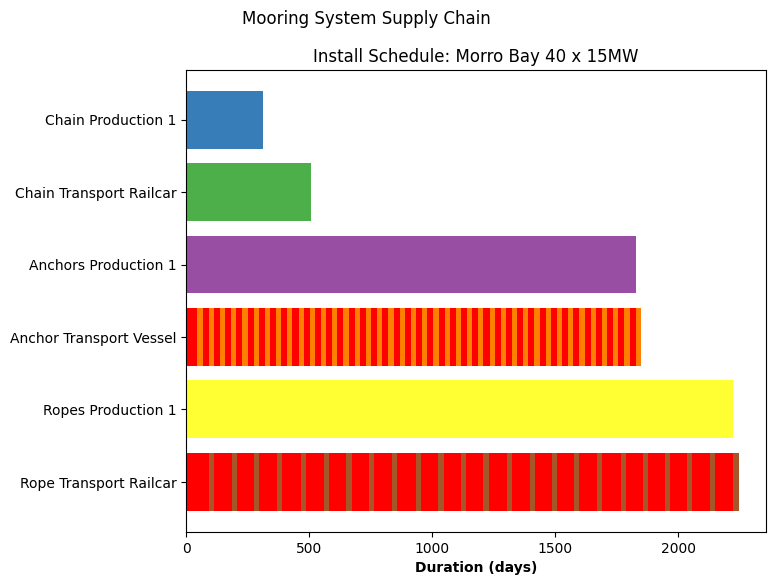

In [7]:
# Plot logic
import numpy as np
plot_based_on = 'agent'

agents = df_actions_MB['agent'].unique()
print(agents)

#wrapped_agents_dic = [textwrap.fill(a, width=16) for a in agents]

color_sns_hex= (sns.color_palette("Set1").as_hex() +
                sns.color_palette("Set2").as_hex() +
                sns.color_palette("Set3").as_hex()
)

def color(row):

    c_dict = {agents[i]: color_sns_hex[i+1] for i in range(len(agents))}
    return c_dict[row['agent']]

df_plot = df_actions_MB
df_plot['color'] = df_plot.apply(color, axis=1)

# make delays red
df_plot.loc[df_plot["action"].str.contains('Delay'), "color"] = '#FF0000'

fig, ax = plt.subplots(1, figsize=(10,6))
fig.suptitle("Mooring System Supply Chain")

ax.barh(y=df_plot[plot_based_on],
           width=(df_plot['duration'])/24,
           left=(df_plot['time']-df_plot['duration'])/24,
           color=df_plot.color)

ax.set_title(f"Install Schedule: Morro Bay {num_turbines} x 15MW")

num_x_labels = 5
#day_spacing = int(((df_plot['end_date'].max() - df_plot['start_date'].min()).days)/num_x_labels)
#xticks = np.arange(0, df_plot['days_to_end'].max()+1, day_spacing)
#ax.set_xticks(xticks)
ax.set_xlabel("Duration (days)", fontdict=dict(weight='bold'))

ax.set_yticklabels(agents)
plt.gca().invert_yaxis()
fig.subplots_adjust(left=0.32)

plt.show()